This file is to test my model on the TUH-EEG-seizure data

I call it as new, because I used a new way to save the model (on May 20, 2023)


In [1]:
RUN_PYTHON_SCRIPT = False
MODEL_NAME = "DisMSELoss_step10_dis6_nlay8_ndim512_epoch2"
SAVED_MODEL = None

In [2]:
import sys
sys.path.append("../mypkg")
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT, MIDRES_ROOT

In [3]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from easydict import EasyDict as edict
from collections import defaultdict as ddict
import time

if not RUN_PYTHON_SCRIPT:
    plt.style.use(FIG_ROOT/"base.mplstyle")

In [4]:
import importlib
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [5]:
from models.model_utils import generate_position_encode, load_model_class
from data_utils.eeg_load import EEG_data, MyDataLoader
from data_utils.utils import convert_to_type, get_triple, digitize_data, rec_data
from utils.misc import delta_time, load_pkl_folder2dict, save_pkl_dict2folder

In [6]:
# pkgs for pytorch (on Apr 3, 2023)
import torch
import torch.nn as nn
from torch.functional import F
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader
from tqdm import trange, tqdm

torch.set_default_dtype(torch.float64)
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
torch.set_default_device(device)
print(device)

cuda


# Load data and model

In [7]:
model_utils = load_pkl_folder2dict(RES_ROOT/f"{MODEL_NAME}", including=["config*", "losses*"]);
module = load_model_class(RES_ROOT/MODEL_NAME);
model = module.myNet(model_utils.config);
model.load_state_dict(torch.load(RES_ROOT/MODEL_NAME/"model.pth", map_location=torch.device('cpu')));

Load file /data/rajlab1/user_data/jin/MyResearch/EEG-sz-det_dev/notebooks/../mypkg/../results/DisMSELoss_step10_dis6_nlay8_ndim512_epoch2/config.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/EEG-sz-det_dev/notebooks/../mypkg/../results/DisMSELoss_step10_dis6_nlay8_ndim512_epoch2/losses.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/EEG-sz-det_dev/notebooks/../mypkg/../results/DisMSELoss_step10_dis6_nlay8_ndim512_epoch2/losses_test.pkl
number of parameters: 25.24M


In [8]:
config = model_utils.config
trained_model = model;
pos_enc = generate_position_encode(config.block_size, config.nfeature).unsqueeze(0);

# Inference

## load data

In [9]:
train_data = EEG_data("train_train_health", "AR", 
                      move_dict=dict(winsize=config.block_size+config.move_step,
                                     stepsize=config.block_size+config.move_step, 
                                     marginsize=None),
                      preprocess_dict=dict(is_detrend=True, 
                                      is_drop=True,
                                      target_fs=90, 
                                      filter_limit=[1, 45], 
                                      is_diff=False), 
                      scale_fct=None
                     )
test_data = EEG_data("train_test_health", "AR", 
                      move_dict=dict(winsize=config.block_size+config.move_step,
                                     stepsize=config.block_size+config.move_step,
                                     marginsize=None),
                      preprocess_dict=dict(is_detrend=True, 
                                      is_drop=True,
                                      target_fs=90, 
                                      filter_limit=[1, 45], 
                                      is_diff=False),
                      scale_fct=None
                    )

train_data_loader = MyDataLoader(train_data, batch_size=4, shuffle=False)
test_data_loader = MyDataLoader(test_data, batch_size=4, shuffle=False)
print(len(train_data_loader), len(test_data_loader))

129862 12349


## Check an example

In [30]:
def trans_batch(batch):
    """transform the batch to make it easy for training
    """
    batch_cls = digitize_data(batch, config.k)
    batch_cls = torch.tensor(batch_cls)
    
    X_cls, Y_cls = batch_cls[:, :-config.move_step], batch_cls[:, config.move_step:]
    Y_base_cls = batch_cls[:, (config.move_step-1):-1] # use X_t as prediction of X_t+1

    res = edict()
    res.X_cls = X_cls
    res.Y_cls = Y_cls
    res.Y_base_cls = Y_base_cls
    return res


def _get_res(batch):
    tbatch = trans_batch(batch);
    Y_bases = get_triple(tbatch.Y_base_cls, k=config.k)
    Xs = get_triple(tbatch.X_cls, k=config.k)
    Ys = get_triple(tbatch.Y_cls, k=config.k)
    X_rec = convert_to_type(Xs.rec, "cuda")
    Xp_rec = X_rec+ pos_enc;
    
    trained_model.eval()
    with torch.no_grad():
        Y_pred_prob = trained_model(Xp_rec, X_rec);
    Y_preds = get_triple(Y_pred_prob, k=config.k);

    res = edict()
    res.Y_preds = Y_preds
    res.Xs = Xs
    res.Ys = Ys
    res.Y_bases = Y_bases
    return res

In [31]:
ix = 0
batch = test_data_loader(ix);
res = _get_res(batch);



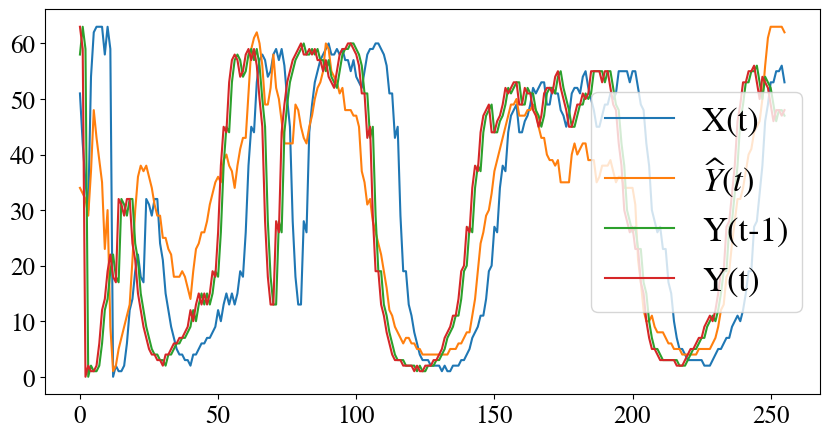

In [32]:
sub_ix = 1
ch_ix = 2
typ = "cls" # cls, rec

plt.plot(res.Xs[typ][sub_ix, :, ch_ix], label="X(t)")
plt.plot(res.Y_preds[typ][sub_ix, :, ch_ix], label=r"$\widehat{Y}(t)$")
plt.plot(res.Y_bases[typ][sub_ix, :, ch_ix], label="Y(t-1)")
plt.plot(res.Ys[typ][sub_ix, :, ch_ix], label="Y(t)")
plt.legend()

## Test on all data

In [9]:
from models.losses import ordinal_mse_loss
ntest = len(test_data_loader);
losses = []
ix = 0
for ix in trange(500):
    batch = test_data_loader(ix);
    res = _get_res(batch);
    
    Y_pred_prob = convert_to_type(res.Y_preds.prob, "cpu");
    Y_base_prob = convert_to_type(res.Y_bases.prob, "cpu");
    X_cls = convert_to_type(res.Xs.cls, "cpu");
    X_prob = convert_to_type(res.Xs.prob, "cpu");
    Y_cls = convert_to_type(res.Ys.cls, "cpu");
    
    lossX = ordinal_mse_loss(output_prob=Y_pred_prob, 
                            target_cls=X_cls, 
                            num_cls=2**config.k)
    lossY = ordinal_mse_loss(output_prob=Y_pred_prob, 
                            target_cls=Y_cls, 
                            num_cls=2**config.k)
    lossXY = ordinal_mse_loss(output_prob=X_prob, 
                            target_cls=Y_cls, 
                            num_cls=2**config.k)
    
    lossX_base = ordinal_mse_loss(output_prob=Y_base_prob, 
                            target_cls=X_cls, 
                            num_cls=2**config.k)
    lossY_base = ordinal_mse_loss(output_prob=Y_base_prob, 
                            target_cls=Y_cls, 
                            num_cls=2**config.k);
    loss = [
        lossX.item(), 
        lossY.item(), 
        lossXY.item(), 
        lossX_base.item(), 
        lossY_base.item(), 
           ]
    losses.append(loss)
losses = np.array(losses);

NameError: name 'test_data_loader' is not defined

In [50]:
import pandas as pd
losses_df = pd.DataFrame(losses);
losses_df.columns = [
r"$\widehat{Y}(t)$ vs $X(t)$",
r"$\widehat{Y}(t)$ vs $Y(t)$",
r"$X(t)$ vs $Y(t)$",
r"$Y(t-1)$ vs $X(t)$",
r"$Y(t-1)$ vs $Y(t)$",
]

losses_df.describe()

,$\widehat{Y}(t)$ vs $X(t)$,$\widehat{Y}(t)$ vs $Y(t)$,$X(t)$ vs $Y(t)$,$Y(t-1)$ vs $X(t)$,$Y(t-1)$ vs $Y(t)$
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.125480,0.146125,0.234316,0.233260,0.149140
std,0.013419,0.010796,0.020934,0.019623,0.032600
min,0.102887,0.125449,0.199427,0.194244,0.049799
25%,0.116719,0.137998,0.220575,0.220255,0.129842
50%,0.122610,0.144664,0.231314,0.231057,0.148588
75%,0.130755,0.153784,0.242658,0.241313,0.165796
max,0.185293,0.174485,0.311239,0.299426,0.228379


# Test on ep data

In [10]:
data_noep = EEG_data("01_no_epilepsy_small", "AR", 
                      root=DATA_ROOT/"EEG_ep",
                      move_dict=dict(winsize=config.block_size+config.move_step,
                                     stepsize=config.block_size+config.move_step, 
                                     marginsize=None),
                      preprocess_dict=dict(is_detrend=True, 
                                      is_drop=True,
                                      target_fs=90, 
                                      filter_limit=[1, 45], 
                                      is_diff=False), 
                      scale_fct=None
                     )
data_ep = EEG_data("00_epilepsy_small", "AR", 
                      root=DATA_ROOT/"EEG_ep",
                      move_dict=dict(winsize=config.block_size+config.move_step,
                                     stepsize=config.block_size+config.move_step, 
                                     marginsize=None),
                      preprocess_dict=dict(is_detrend=True, 
                                      is_drop=True,
                                      target_fs=90, 
                                      filter_limit=[1, 45], 
                                      is_diff=False), 
                      scale_fct=None
                     )
data_noep_loader = MyDataLoader(data_noep, batch_size=16, shuffle=False)
data_ep_loader = MyDataLoader(data_ep, batch_size=16, shuffle=False)

In [11]:
def trans_batch(batch):
    """transform the batch to make it easy for training
    """
    batch_cls = digitize_data(batch, config.k)
    batch_cls = torch.tensor(batch_cls)
    
    X_cls, Y_cls = batch_cls[:, :-config.move_step], batch_cls[:, config.move_step:]
    Y_base_cls = batch_cls[:, (config.move_step-1):-1] # use X_t as prediction of X_t+1

    res = edict()
    res.X_cls = X_cls
    res.Y_cls = Y_cls
    res.Y_base_cls = Y_base_cls
    return res


def _get_res(batch):
    tbatch = trans_batch(batch);
    Y_bases = get_triple(tbatch.Y_base_cls, k=config.k)
    Xs = get_triple(tbatch.X_cls, k=config.k)
    Ys = get_triple(tbatch.Y_cls, k=config.k)
    X_rec = convert_to_type(Xs.rec, "cuda")
    Xp_rec = X_rec+ pos_enc;
    
    trained_model.eval()
    with torch.no_grad():
        Y_pred_prob = trained_model(Xp_rec, X_rec);
    Y_preds = get_triple(Y_pred_prob, k=config.k);

    res = edict()
    res.Y_preds = Y_preds
    res.Xs = Xs
    res.Ys = Ys
    res.Y_bases = Y_bases
    return res

In [14]:
batch = data_ep_loader(0);
res = _get_res(batch);

<Axes: >

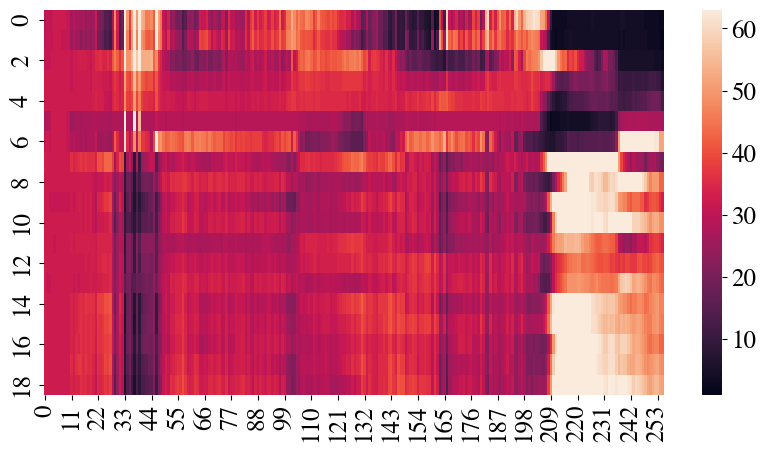

In [20]:
sns.heatmap(res.Y_preds.cls[0].T)

In [23]:
print(res.Y_preds.prob.shape)

(16, 256, 19, 64)


In [24]:
res.Y_preds.prob[0, 0, 0]

array([4.58614059e-08, 1.21893235e-07, 3.12953068e-07, 7.76151182e-07,
       1.85943526e-06, 4.30312098e-06, 9.61953155e-06, 2.07726680e-05,
       4.33310027e-05, 8.73118930e-05, 1.69948126e-04, 3.19541861e-04,
       5.80373589e-04, 1.01825396e-03, 1.72573157e-03, 2.82526462e-03,
       4.46800691e-03, 6.82554653e-03, 1.00723308e-02, 1.43579203e-02,
       1.97707052e-02, 2.62979499e-02, 3.37902015e-02, 4.19400421e-02,
       5.02847351e-02, 5.82388411e-02, 6.51566213e-02, 7.04163774e-02,
       7.35119774e-02, 7.41330452e-02, 7.22162424e-02, 6.79559112e-02,
       6.17716058e-02, 5.42400181e-02, 4.60065878e-02, 3.76954958e-02,
       2.98351418e-02, 2.28105588e-02, 1.68466238e-02, 1.20187393e-02,
       8.28273932e-03, 5.51388941e-03, 3.54577382e-03, 2.20258594e-03,
       1.32167136e-03, 7.66095315e-04, 4.28954037e-04, 2.32010295e-04,
       1.21219421e-04, 6.11794417e-05, 2.98268282e-05, 1.40467803e-05,
       6.39020144e-06, 2.80814960e-06, 1.19204800e-06, 4.88804212e-07,
      